# 画像ファイルに対応するキロ程紐づけ用のJSONファイルを作成するノートブック
```
以下のコマンドを順番に実行していく
想定しているディレクトリ構造は以下のとおり
.
├ imgs
│  └ dir_area    :線区単位の画像を保存
│     ├ HD11     :カメラ毎の画像を保存
│     ├ HD12     :以下、同じ
│     ├ HD21         
│     ├ HD21 
│     ├ HD31 
│     └ HD32 
├ TDM
│  └ TDM_GazoFileIndex.xlsx  :車モニから出力したマスターデータ
└ imgKiro.ipynb  :本ファイル
```

# 一括で線区フォルダごとのJSONファイルを作成する

## 1. ライブラリ読込み＆関数の定義

In [307]:
import importlib
from pprint import pprint

import gc
import re
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFont
from src.config import appProperties
import src.helpers as helpers
import src.visualize as vis
importlib.reload(helpers)
importlib.reload(vis)

config = appProperties('config.yml')


def get_df(tdm_fpath):
    """ 車モニのマスタデータを読み込む
    Args:
        tdm_fpath(str): 車モニ マスターデータのパス
    Return:
        df_tdm(DataFrame): 読み込まれたデータフレーム
    """ 
    print("車モニのマスターデータを読み込みます ※少し時間がかかります")
    df_tdm = pd.read_excel(tdm_fpath)
    df_tdm['TimeCode'] = pd.to_datetime(df_tdm['TimeCode'])
    df_tdm = df_tdm.sort_values(by=['SokuteiDate', 'KiroTei'], ignore_index=True)
    print("車モニのマスターデータを読み込みました")
    print(f"データフレームのサイズ:{df_tdm.shape}")
    # 欲しい列だけ抽出する
    df_tdm = df_tdm.filter([
        'EkiCd', 'SenbetsuCd', 'SokuteiDate', 'DenchuNo', 'KiroTei', 'GazoFileNameHD11', 'GazoFileNameHD12',
        'GazoFileNameHD21', 'GazoFileNameHD22', 'GazoFileNameHD31', 'GazoFileNameHD32'
    ]).copy()
    print("必要な情報だけフィルタリングしました")
    print(f"データフレームのサイズ:{df_tdm.shape}")
    return df_tdm


def get_KiroTei_dict(config, df):
    """ 走行日・線区ごとのキロ程補正情報を辞書に記録する
    """
    # カメラ番号ごとに、EkiCdのはじめの行をTrueとして記録する
    for camera_num in config.camera_types:
        df[f"EkiCdDiff{camera_num}"] = df.query(f"GazoFileName{camera_num}.notnull()")['EkiCd'].diff().map(lambda x: x != 0)
    # 走行日・線区ごとに、画像1枚あたりの幅(m)を算出して辞書に記録する
    result_dict = {}
    for camera_num in config.camera_types:
        grouped_df = df.query(f"GazoFileName{camera_num}.notnull()").groupby(['SokuteiDate', 'EkiCd'])['KiroTei_NEWSS'].count()
        for (date, ekicd), count in grouped_df.items():
            if date not in result_dict:
                result_dict[date] = {}
            if ekicd not in result_dict[date]:
                result_dict[date][ekicd] = {}
            # print(f"camera_num: {camera_num}, date: {date}, ekicd: {ekicd}")
            KiroTei_head = df.query(f"EkiCdDiff{camera_num}.notnull() & SokuteiDate == {date} & EkiCd == {ekicd}")['KiroTei_NEWSS'].iloc[0]
            KiroTei_tail = df.query(f"EkiCdDiff{camera_num}.notnull() & SokuteiDate == {date} & EkiCd == {ekicd}")['KiroTei_NEWSS'].iloc[-1]
            result_dict[date][ekicd][camera_num] = {
                'KiroTei_head': KiroTei_head,
                'KiroTei_tail': KiroTei_tail,
                'KiroTei_dist': round(KiroTei_tail - KiroTei_head, 4),
                'KiroTei_delta': round((KiroTei_tail - KiroTei_head) / (count - 1), 6),
                'count': count
            }
    return df, result_dict


def get_Kiro_offset(df_tdm, ref_point, date):
    """ 基準位置を指定し、検測キロ程をNEWSSキロ程に変換するオフセット値を取得する
    Args:
    
    Return:
    
    """
    pole_num_matched = df_tdm.query(
        f"EkiCd == {ref_point['EkiCd_NEWSS']} & SokuteiDate == {date} & DenchuNo == {ref_point['pole_num_NEWSS']}"
    ).index.tolist()
    pole_kiro_twins = df_tdm.loc[min(pole_num_matched)]['KiroTei']
    pole_kiro_offset = ref_point['pole_kilo_NEWSS'] - pole_kiro_twins
    print(f"基準にする電柱の検測キロ程: {pole_kiro_twins}km")
    print(f"　　　キロ程のオフセット値: {pole_kiro_offset}km")
    return pole_kiro_offset


def get_Kiro_NEWSS(df_tdm, kiro_offset_dict):
    df_tdm['KiroTei_NEWSS'] = df_tdm.apply(lambda row: row['KiroTei'] + kiro_offset_dict[row['SokuteiDate']], axis=1)
    return df_tdm


def set_imgKiro(config, dir_area, df_tdm):
    imgKilo = {}
    for camera_num in config.camera_types:
        # カメラフォルダ内の画像ファイルを取得
        image_dir = f"{config.image_dir}/{dir_area}/{camera_num}/"
        print(image_dir)
        list_images = helpers.list_images(image_dir)
        print(f"Image counts:{len(list_images)}")
        # 画像ファイル名に対応するキロ程を抽出して辞書型で記録する
        imgKilo_temp = {}
        # imgKilo_temp_values = {}
        for fname in tqdm(list_images):
        # for fname in list_images:
            image_name = re.split('[./]', fname)[-2]
            df_tdm_Series = df_tdm[df_tdm[f"GazoFileName{camera_num}"] == image_name].copy()
            if df_tdm_Series.empty:
                continue
            else:
                DenchuNo = df_tdm_Series['DenchuNo'].item()
                KiroTei = df_tdm_Series['KiroTei_NEWSS'].round(4).item()

            # imgKilo_temp_values["DenchuNo"] = DenchuNo
            # imgKilo_temp_values["KiroTei"] = KiroTei
            # imgKilo_temp[image_name] = imgKilo_temp_values.copy()
            imgKilo_temp[image_name] = {
                "DenchuNo": DenchuNo,
                "KiroTei": KiroTei
            }
        imgKilo[camera_num] = imgKilo_temp.copy()

    return imgKilo


print("準備完了")

準備完了


## 2. 車モニデータを利用して画像ごとのキロ程マスターデータ(JSON)を作成する
```
ファイルパスなどを設定する
車モニのマスターデータは検測キロ程になっているため、NEWSSキロ程に合わせる基準を設定する
```

In [308]:
# まとめて処理用

# 初期設定
images_path = helpers.list_imagespath_nonCache(config.image_dir)
ref_point = {
    "EkiCd_NEWSS": 14010,    # 高崎線での初期値 14010: 宮原
    "pole_num_NEWSS": 1,    # 高崎線での初期値 1: 構本1号柱
    "pole_kilo_NEWSS": 3.561    # 高崎線での初期値 3.561: NEWSSキロ程3k561m
}
print("キロ程変換の基準")
print(f"> 駅コード: {ref_point['EkiCd_NEWSS']}")
print(f"> 基準にする電柱：{ref_point['pole_num_NEWSS']}号柱 {ref_point['pole_kilo_NEWSS']}km")

# 車モニのマスターデータのファイルパス
tdm_fpath = f'{config.tdm_dir}/TDM_GazoFileIndex.xlsx'
print(f"車モニ マスターデータのファイルパス:{tdm_fpath}")
# 車モニのマスタデータを読み込む
df_tdm = get_df(tdm_fpath)

# 走行日・線区ごとのキロ程補正情報の辞書を作成する
df_tdm, KiroTei_dict = get_KiroTei_dict(config, df_tdm)


"""
    KiroTei_dict を使って、NEWSSキロ程と合うようにキロ程を補正するコードに修正する👇
    NEWSS諸元からデータを引っ張ってくる？
    それとも、走行日毎にオフセット⇒画像毎の距離だけ補正してあげる？
"""


# 車モニ マスターデータにおける、基準にする電柱の検測キロ程を取得
# オフセット値を設定する
SokuteiDate = df_tdm['SokuteiDate'].unique()
kiro_offset_dict = {}
print("読み込まれたデータベースに含まれる測定日↓")
for i, date in enumerate(SokuteiDate):
    # 線別コードを取得
    SenbetsuCd = df_tdm[df_tdm['SokuteiDate'] == date]['SenbetsuCd'].unique().item()
    print(f"{i}> 走行日：{date} 線別：{config.SenbetsuCd[SenbetsuCd]}")
    pole_kiro_offset = get_Kiro_offset(df_tdm, ref_point, date)
    kiro_offset_dict[date] = pole_kiro_offset
print("測定日ごとのキロ程オフセット")
pprint(kiro_offset_dict)

print("NEWSSキロ程に合うように、キロ程をオフセットしました")

# NEWSSキロ程を計算して 列`KiroTei_NEWSS`に記録する
df_tdm = get_Kiro_NEWSS(df_tdm, kiro_offset_dict)

# 線区フォルダごとに JSON ファイルを作成する
for dir_area in images_path:
    # 測定日・走行条件を表示する
    SokuteiDate = df_tdm['SokuteiDate'].unique()

    # 初期設定の情報を出力
    print(f"画像フォルダ名：{dir_area}")
    print(f"基準にする電柱：{ref_point['pole_num_NEWSS']}")
    print(f"　　　　キロ程：{ref_point['pole_kilo_NEWSS']}")
    print(f"検測キロ程ズレ：{kiro_offset_dict[int(dir_area.split('_')[-2])]}")

    imgKilo = set_imgKiro(config, dir_area, df_tdm)

    # 結果をJSONファイルに記録する
    dir = f"{config.tdm_dir}/{dir_area}.json"
    with open(dir, mode="wt", encoding="utf-8") as f:
        json.dump(imgKilo, f, ensure_ascii=False, indent=2, default=helpers.default)

    print(f"画像ファイルごとのキロ程情報を{dir}に記録しました")


キロ程変換の基準
> 駅コード: 14010
> 基準にする電柱：1号柱 3.561km
車モニ マスターデータのファイルパス:TDM/TDM_GazoFileIndex.xlsx
車モニのマスターデータを読み込みます ※少し時間がかかります
車モニのマスターデータを読み込みました
データフレームのサイズ:(53398, 90)
必要な情報だけフィルタリングしました
データフレームのサイズ:(53398, 11)


KeyError: 'Column not found: KiroTei_NEWSS'

# 個別機能の検証

In [137]:
# 初期設定

# 車モニのマスターデータのファイルパス
tdm_fpath = f'{config.tdm_dir}/TDM_GazoFileIndex.xlsx'
print(f"車モニ マスターデータのファイルパス:{tdm_fpath}")

# 画像ファイルを保存したフォルダ
dir_area = "Takasaki_99_Omiya-Kitaageo_down_20230509_day"
print(f"解析対象フォルダ:{dir_area}")

# 境界部でのNEWSSキロ程
# 例) 1号柱のキロ程を指定する
#    電柱番号: int型
#    キロ程  : float型 km単位
ref_point = {
    "EkiCd_NEWSS": 14010,
    "pole_num_NEWSS": 1,
    "pole_kilo_NEWSS": 3.561
}
print("キロ程変換の基準")
print(f"> 駅コード: {ref_point['EkiCd_NEWSS']}")
print(f"> 基準にする電柱：{ref_point['pole_num_NEWSS']}号柱 {ref_point['pole_kilo_NEWSS']}km")

車モニ マスターデータのファイルパス:TDM/TDM_GazoFileIndex.xlsx
解析対象フォルダ:Takasaki_99_Omiya-Kitaageo_down_20230509_day
キロ程変換の基準
> 駅コード: 14010
> 基準にする電柱：1号柱 3.561km


## 3. 車モニのマスターデータを読込んでいく

In [299]:
%%time
# 車モニのマスタデータを読み込む
df_tdm = get_df(tdm_fpath)


車モニのマスターデータを読み込みます ※少し時間がかかります
車モニのマスターデータを読み込みました
データフレームのサイズ:(53398, 90)
必要な情報だけフィルタリングしました
データフレームのサイズ:(53398, 11)
CPU times: user 45.5 s, sys: 113 ms, total: 45.6 s
Wall time: 1min 1s


In [300]:
df_tdm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53398 entries, 0 to 53397
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EkiCd             53398 non-null  int64  
 1   SenbetsuCd        53398 non-null  int64  
 2   SokuteiDate       53398 non-null  int64  
 3   DenchuNo          53398 non-null  int64  
 4   KiroTei           53398 non-null  float64
 5   GazoFileNameHD11  25931 non-null  object 
 6   GazoFileNameHD12  25931 non-null  object 
 7   GazoFileNameHD21  25933 non-null  object 
 8   GazoFileNameHD22  25933 non-null  object 
 9   GazoFileNameHD31  25933 non-null  object 
 10  GazoFileNameHD32  25933 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.5+ MB


In [301]:
# 車モニ マスターデータにおける、基準にする電柱の検測キロ程を取得
# オフセット値を設定する
SokuteiDate = df_tdm['SokuteiDate'].unique()
kiro_offset_dict = {}
print("読み込まれたデータベースに含まれる測定日↓")
for i, date in enumerate(SokuteiDate):
    # 線別コードを取得
    SenbetsuCd = df_tdm[df_tdm['SokuteiDate'] == date]['SenbetsuCd'].unique().item()
    print(f"{i}> 走行日：{date} 線別：{config.SenbetsuCd[SenbetsuCd]}")
    pole_kiro_offset = get_Kiro_offset(df_tdm, ref_point, date)
    kiro_offset_dict[date] = pole_kiro_offset
print("測定日ごとのキロ程オフセット")
pprint(kiro_offset_dict)

print("NEWSSキロ程に合うように、キロ程をオフセットしました")

# NEWSSキロ程を計算して 列`KiroTei_NEWSS`に記録する
df_tdm = get_Kiro_NEWSS(df_tdm, kiro_offset_dict)

読み込まれたデータベースに含まれる測定日↓
0> 走行日：20220917 線別：下り線
基準にする電柱の検測キロ程: 1.9815km
　　　キロ程のオフセット値: 1.5795km
1> 走行日：20221130 線別：下り線
基準にする電柱の検測キロ程: 1.9815km
　　　キロ程のオフセット値: 1.5795km
2> 走行日：20230216 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
3> 走行日：20230509 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
4> 走行日：20230510 線別：上り線
基準にする電柱の検測キロ程: 1.9647km
　　　キロ程のオフセット値: 1.5963km
5> 走行日：20230920 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
6> 走行日：20230921 線別：上り線
基準にする電柱の検測キロ程: 1.9697km
　　　キロ程のオフセット値: 1.5913km
測定日ごとのキロ程オフセット
{20220917: 1.5795,
 20221130: 1.5795,
 20230216: 1.5765,
 20230509: 1.5765,
 20230510: 1.5963,
 20230920: 1.5765,
 20230921: 1.5913}
NEWSSキロ程に合うように、キロ程をオフセットしました


やりたいこと👇
1. 一度、基準点として指定した電柱番号・キロ程を使って TWINSキロ程 -> NEWSSキロ程 に書き換える
2. 画像あたりの距離が 2m になっていない可能性が高いため、区間長 / 画像枚数 で画像の横幅に対応する距離を補正してキロ程の被りを無くす

In [304]:
# 走行日・線区ごとのキロ程補正情報の辞書を作成する
df_tdm, KiroTei_dict = get_KiroTei_dict(config, df_tdm)

In [305]:
df_tdm

,EkiCd,SenbetsuCd,SokuteiDate,DenchuNo,KiroTei,GazoFileNameHD11,GazoFileNameHD12,GazoFileNameHD21,GazoFileNameHD22,GazoFileNameHD31,GazoFileNameHD32,KiroTei_NEWSS,EkiCdDiffHD11,EkiCdDiffHD12,EkiCdDiffHD21,EkiCdDiffHD22,EkiCdDiffHD31,EkiCdDiffHD32
0,14018,21,20220917,33,1.4203,NaN,NaN,NaN,NaN,NaN,NaN,2.9998,NaN,NaN,NaN,NaN,NaN,NaN
1,14018,21,20220917,33,1.4213,2022_0347_HD11_01_00015331,2022_0347_HD12_01_00015331,2022_0347_HD21_01_00015332,2022_0347_HD22_01_00015332,2022_0347_HD31_01_00015331,2022_0347_HD32_01_00015331,3.0008,True,True,True,True,True,True
2,14018,21,20220917,33,1.4213,NaN,NaN,NaN,NaN,NaN,NaN,3.0008,NaN,NaN,NaN,NaN,NaN,NaN
3,14018,21,20220917,33,1.4223,NaN,NaN,NaN,NaN,NaN,NaN,3.0018,NaN,NaN,NaN,NaN,NaN,NaN
4,14018,21,20220917,33,1.4233,2022_0347_HD11_01_00015332,2022_0347_HD12_01_00015332,2022_0347_HD21_01_00015333,2022_0347_HD22_01_00015333,2022_0347_HD31_01_00015332,2022_0347_HD32_01_00015332,3.0028,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53393,14200,22,20230921,12,8.5438,2023_0379_HD11_01_00073022,2023_0379_HD12_01_00073022,2023_0379_HD21_01_00073025,2023_0379_HD22_01_00073025,2023_0379_HD31_01_00073024,2023_0379_HD32_01_00073024,10.1351,False,False,False,False,False,False
53394,14200,22,20230921,12,8.5448,NaN,NaN,2023_0379_HD21_01_00073024,2023_0379_HD22_01_00073024,NaN,NaN,10.1361,NaN,NaN,False,False,NaN,NaN
53395,14200,22,20230921,12,8.5448,NaN,NaN,NaN,NaN,NaN,NaN,10.1361,NaN,NaN,NaN,NaN,NaN,NaN
53396,14200,22,20230921,12,8.5458,2023_0379_HD11_01_00073021,2023_0379_HD12_01_00073021,NaN,NaN,2023_0379_HD31_01_00073023,2023_0379_HD32_01_00073023,10.1371,False,False,NaN,NaN,False,False


## 作業用

In [254]:
df_tdm['SokuteiDate'].unique()

array([20220917, 20221130, 20230216, 20230509, 20230510, 20230920,
       20230921])

In [255]:
df_tdm[df_tdm['SokuteiDate']==20230509]['EkiCd'].unique()

array([14018, 14010, 14019, 14020, 14029, 14200])

In [256]:
# テスト用のデータフレームを作成
df_tdm_temp = df_tdm.copy()
df_tdm_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53398 entries, 0 to 53397
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EkiCd             53398 non-null  int64  
 1   SenbetsuCd        53398 non-null  int64  
 2   SokuteiDate       53398 non-null  int64  
 3   DenchuNo          53398 non-null  int64  
 4   KiroTei           53398 non-null  float64
 5   GazoFileNameHD11  25931 non-null  object 
 6   GazoFileNameHD12  25931 non-null  object 
 7   GazoFileNameHD21  25933 non-null  object 
 8   GazoFileNameHD22  25933 non-null  object 
 9   GazoFileNameHD31  25933 non-null  object 
 10  GazoFileNameHD32  25933 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.5+ MB


In [257]:
# カメラ番号ごとに、EkiCdのはじめの行をTrueとして記録する
for camera_num in config.camera_types:
    df_tdm_temp[f"EkiCdDiff{camera_num}"] = df_tdm_temp.query(f"GazoFileName{camera_num}.notnull()")['EkiCd'].diff().map(lambda x: x != 0)
df_tdm_temp

,EkiCd,SenbetsuCd,SokuteiDate,DenchuNo,KiroTei,GazoFileNameHD11,GazoFileNameHD12,GazoFileNameHD21,GazoFileNameHD22,GazoFileNameHD31,GazoFileNameHD32,EkiCdDiffHD11,EkiCdDiffHD12,EkiCdDiffHD21,EkiCdDiffHD22,EkiCdDiffHD31,EkiCdDiffHD32
0,14018,21,20220917,33,1.4203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14018,21,20220917,33,1.4213,2022_0347_HD11_01_00015331,2022_0347_HD12_01_00015331,2022_0347_HD21_01_00015332,2022_0347_HD22_01_00015332,2022_0347_HD31_01_00015331,2022_0347_HD32_01_00015331,True,True,True,True,True,True
2,14018,21,20220917,33,1.4213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14018,21,20220917,33,1.4223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14018,21,20220917,33,1.4233,2022_0347_HD11_01_00015332,2022_0347_HD12_01_00015332,2022_0347_HD21_01_00015333,2022_0347_HD22_01_00015333,2022_0347_HD31_01_00015332,2022_0347_HD32_01_00015332,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53393,14200,22,20230921,12,8.5438,2023_0379_HD11_01_00073022,2023_0379_HD12_01_00073022,2023_0379_HD21_01_00073025,2023_0379_HD22_01_00073025,2023_0379_HD31_01_00073024,2023_0379_HD32_01_00073024,False,False,False,False,False,False
53394,14200,22,20230921,12,8.5448,NaN,NaN,2023_0379_HD21_01_00073024,2023_0379_HD22_01_00073024,NaN,NaN,NaN,NaN,False,False,NaN,NaN
53395,14200,22,20230921,12,8.5448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53396,14200,22,20230921,12,8.5458,2023_0379_HD11_01_00073021,2023_0379_HD12_01_00073021,NaN,NaN,2023_0379_HD31_01_00073023,2023_0379_HD32_01_00073023,False,False,NaN,NaN,False,False


In [240]:
camera_num = config.camera_types[0]
df_tdm_temp[f"EkiCdDiff{camera_num}"] = df_tdm_temp.query(f"GazoFileName{camera_num}.notnull()")['EkiCd'].diff().map(lambda x: x != 0)

In [267]:
camera_num = config.camera_types[0]
date = 20230921
ekicd = 14200
# df_tdm_temp.query(f"EkiCdDiff{camera_num} == True & SokuteiDate == {date} & EkiCd == {ekicd}")["KiroTei"].iloc[-1]
df_tdm_temp.query(f"EkiCdDiff{camera_num}.notnull() & SokuteiDate == {date} & EkiCd == {ekicd}")['KiroTei'].iloc[-1]

7.9401
8.5458


In [285]:
# 走行日・線区ごとのキロ程補正情報の辞書を作成する
KiroTei_dict = get_KiroTei_dict(config, df_tdm)
KiroTei_dict

{20220917: {14010: {'HD11': {'KiroTei_head': 1.9505,
    'KiroTei_tail': 3.0565,
    'KiroTei_dist': 1.106,
    'KiroTei_delta': 0.00194,
    'count': 571},
   'HD12': {'KiroTei_head': 1.9505,
    'KiroTei_tail': 3.0565,
    'KiroTei_dist': 1.106,
    'KiroTei_delta': 0.00194,
    'count': 571},
   'HD21': {'KiroTei_head': 1.9505,
    'KiroTei_tail': 3.0565,
    'KiroTei_dist': 1.106,
    'KiroTei_delta': 0.00194,
    'count': 571},
   'HD22': {'KiroTei_head': 1.9505,
    'KiroTei_tail': 3.0565,
    'KiroTei_dist': 1.106,
    'KiroTei_delta': 0.00194,
    'count': 571},
   'HD31': {'KiroTei_head': 1.9505,
    'KiroTei_tail': 3.0565,
    'KiroTei_dist': 1.106,
    'KiroTei_delta': 0.00194,
    'count': 571},
   'HD32': {'KiroTei_head': 1.9505,
    'KiroTei_tail': 3.0565,
    'KiroTei_dist': 1.106,
    'KiroTei_delta': 0.00194,
    'count': 571}},
  14018: {'HD11': {'KiroTei_head': 1.4213,
    'KiroTei_tail': 1.9485,
    'KiroTei_dist': 0.5272,
    'KiroTei_delta': 0.001917,
    'count':

2024/6/14時点のメモ（長山->山澤さん）
駅コード/測定日ごとの、画像1枚当たりの長さ(KiroTei_delta)を計算して辞書にするまでは作れましたが.............

👇ここで力尽きました…orz

In [295]:
SokuteiDate = df_tdm['SokuteiDate'].unique()
kiro_offset_dict = {}
print("読み込まれたデータベースに含まれる測定日↓")
for i, date in enumerate(SokuteiDate):
    # 線別コードを取得
    SenbetsuCd = df_tdm[df_tdm['SokuteiDate'] == date]['SenbetsuCd'].unique().item()
    print(f"{i}> 走行日：{date} 線別：{config.SenbetsuCd[SenbetsuCd]}")
    pole_kiro_offset = get_Kiro_offset(df_tdm, ref_point, date)
    kiro_offset_dict[date] = pole_kiro_offset
print("測定日ごとのキロ程オフセット")
pprint(kiro_offset_dict)

print("NEWSSキロ程に合うように、キロ程をオフセットしました")

読み込まれたデータベースに含まれる測定日↓
0> 走行日：20220917 線別：下り線
基準にする電柱の検測キロ程: 1.9815km
　　　キロ程のオフセット値: 1.5795km
1> 走行日：20221130 線別：下り線
基準にする電柱の検測キロ程: 1.9815km
　　　キロ程のオフセット値: 1.5795km
2> 走行日：20230216 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
3> 走行日：20230509 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
4> 走行日：20230510 線別：上り線
基準にする電柱の検測キロ程: 1.9647km
　　　キロ程のオフセット値: 1.5963km
5> 走行日：20230920 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
6> 走行日：20230921 線別：上り線
基準にする電柱の検測キロ程: 1.9697km
　　　キロ程のオフセット値: 1.5913km
測定日ごとのキロ程オフセット
{20220917: 1.5795,
 20221130: 1.5795,
 20230216: 1.5765,
 20230509: 1.5765,
 20230510: 1.5963,
 20230920: 1.5765,
 20230921: 1.5913}
NEWSSキロ程に合うように、キロ程をオフセットしました


In [296]:
# NEWSSキロ程を計算して 列`KiroTei_NEWSS`に記録する
df_tdm = get_Kiro_NEWSS(df_tdm, kiro_offset_dict)

In [298]:
df_tdm.to_csv('temp.csv', encoding="cp932")

In [143]:
df_tdm_temp[df_tdm_temp['SokuteiDate']==20230509]['EkiCd'].unique()

array([14018, 14010, 14019, 14020, 14029, 14200])

In [ ]:
df_tdm_temp

In [157]:
%%timeit
# EkiCodeの変化点にフラグを記録する
df_tdm_temp['EkiCd_ChangeFlag'] = df_tdm_temp['EkiCd'].diff().apply(lambda x: x != 0)

14.5 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [145]:
df_tdm_temp['EkiCd_ChangeFlag'].unique()

array([ True, False])

In [55]:
df_tdm[df_tdm['SokuteiDate']==20230509]['KiroTei']

24712    1.4203
24713    1.4213
24714    1.4223
24715    1.4233
24716    1.4243
          ...  
31195    8.5656
31196    8.5666
31197    8.5676
31198    8.5686
31199    8.5696
Name: KiroTei, Length: 7618, dtype: float64

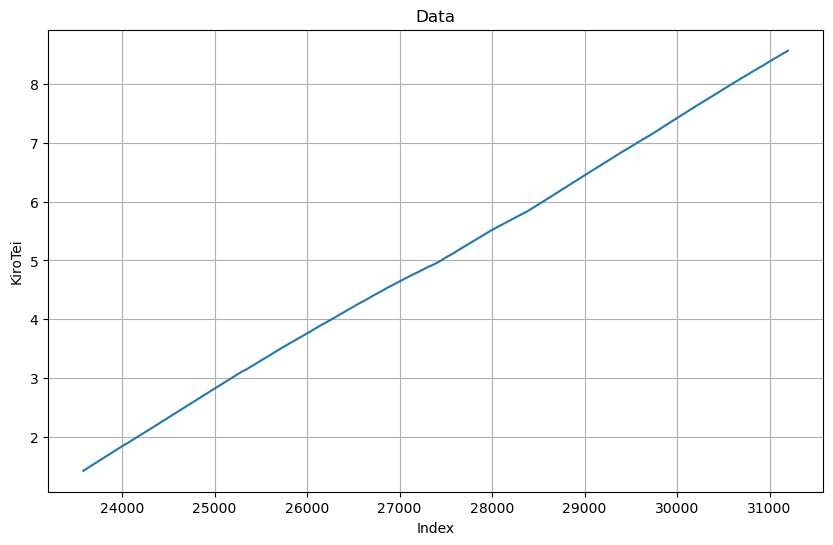

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

data = df_tdm[df_tdm['SokuteiDate']==20230509]['KiroTei'].copy()

plt.figure(figsize=(10, 6))
data.plot(kind='line')
plt.title('Data')
plt.xlabel('Index')
plt.ylabel('KiroTei')
plt.grid(True)
plt.show()

### 出力したJSONファイルをチェックする

In [170]:
def load_json_to_dataframe(file_path, camera_num):
    # JSONファイルを読み込む
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Pandasデータフレームに変換
    df = pd.DataFrame(data[camera_num]).T
    df.insert(0, 'file_name', df.index)
    df.insert(1, 'camera_num', df['file_name'].apply(extract_camera_num))
    df.insert(2, 'file_index', df['file_name'].apply(extract_file_index))
    
    return df


def extract_camera_num(file_name):
    match = re.search(r'HD\d{2}', file_name)
    return match.group(0) if match else None


def extract_file_index(file_name):
    match = re.search(r'\d+$', file_name)
    return int(match.group(0)) if match else None
    


file_path = "TDM/Takasaki_99_Omiya-Kitaageo_down_20230509_day.json"

dfs = []
for camera_num in config.camera_types:
    dfs.append(load_json_to_dataframe(file_path, camera_num))
df_json = pd.concat(dfs, ignore_index=True)
df_json

,file_name,camera_num,file_index,DenchuNo,KiroTei
0,2023_0117_HD11_01_00015339,HD11,15339,33.0,2.99680
1,2023_0117_HD11_01_00015340,HD11,15340,33.0,2.99880
2,2023_0117_HD11_01_00015341,HD11,15341,33.0,3.00080
3,2023_0117_HD11_01_00015342,HD11,15342,33.0,3.00280
4,2023_0117_HD11_01_00015343,HD11,15343,33.0,3.00480
...,...,...,...,...,...
20503,2023_0117_HD32_01_00018752,HD32,18752,1.0,9.57848
20504,2023_0117_HD32_01_00018753,HD32,18753,1.0,9.58050
20505,2023_0117_HD32_01_00018754,HD32,18754,1.0,9.58252
20506,2023_0117_HD32_01_00018755,HD32,18755,1.0,9.58454


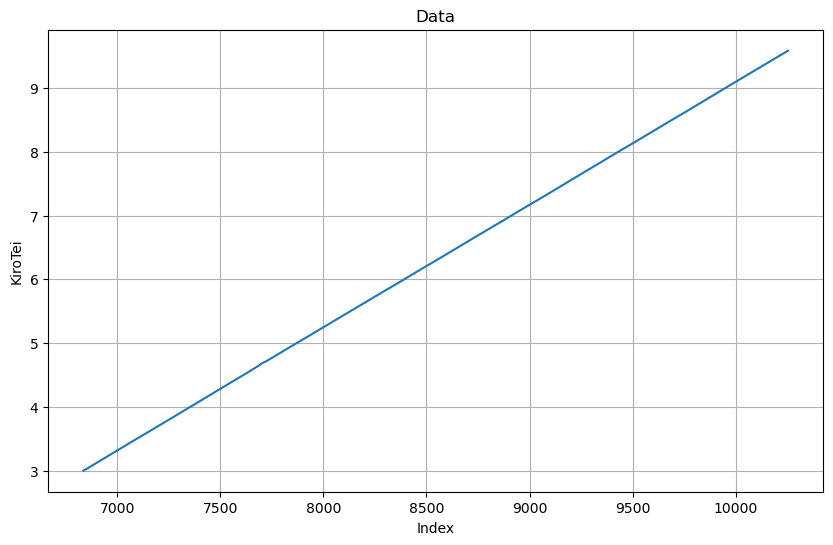

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt


df_json = df_json.sort_values('file_name')
data = df_json[df_json['camera_num']=='HD21']['KiroTei'].copy()

plt.figure(figsize=(10, 6))
data.plot(kind='line')
plt.title('Data')
plt.xlabel('Index')
plt.ylabel('KiroTei')
plt.grid(True)
plt.show()

## 4. データの前処理・NEWSSキロ程に変換する

In [123]:
SokuteiDate = df_tdm['SokuteiDate'].unique()
kiro_offset_dict = {}
print("読み込まれたデータベースに含まれる測定日↓")
for i, date in enumerate(SokuteiDate):
    # 線別コードを取得
    SenbetsuCd = df_tdm[df_tdm['SokuteiDate'] == date]['SenbetsuCd'].unique().item()
    print(f"{i}> 走行日：{date} 線別：{config.SenbetsuCd[SenbetsuCd]}")
    pole_kiro_offset = get_Kiro_offset(df_tdm, ref_point, date)
    kiro_offset_dict[date] = pole_kiro_offset
    
print("測定日ごとのキロ程オフセット")
pprint(kiro_offset_dict)

読み込まれたデータベースに含まれる測定日↓
0> 走行日：20220917 線別：下り線
基準にする電柱の検測キロ程: 1.9815km
　　　キロ程のオフセット値: 1.5795km
1> 走行日：20221130 線別：下り線
基準にする電柱の検測キロ程: 1.9815km
　　　キロ程のオフセット値: 1.5795km
2> 走行日：20230216 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
3> 走行日：20230509 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
4> 走行日：20230510 線別：上り線
基準にする電柱の検測キロ程: 2.0037km
　　　キロ程のオフセット値: 1.5573000000000001km
5> 走行日：20230920 線別：下り線
基準にする電柱の検測キロ程: 1.9845km
　　　キロ程のオフセット値: 1.5765km
6> 走行日：20230921 線別：上り線
基準にする電柱の検測キロ程: 2.0087km
　　　キロ程のオフセット値: 1.5522999999999998km
測定日ごとのキロ程オフセット
{20220917: 1.5795,
 20221130: 1.5795,
 20230216: 1.5765,
 20230509: 1.5765,
 20230510: 1.5573000000000001,
 20230920: 1.5765,
 20230921: 1.5522999999999998}


In [150]:
# NEWSSキロ程を計算して 列`KiroTei_NEWSS`に記録する
df_tdm = get_Kiro_NEWSS(df_tdm, kiro_offset_dict)
df_tdm

,EkiCd,SenbetsuCd,SokuteiDate,DenchuNo,KiroTei,GazoFileNameHD11,GazoFileNameHD12,GazoFileNameHD21,GazoFileNameHD22,GazoFileNameHD31,GazoFileNameHD32,KiroTei_NEWSS,offset_check
0,14018,21,20220917,33,1.42030,NaN,NaN,NaN,NaN,NaN,NaN,2.99980,1.5795
1,14018,21,20220917,33,1.42130,2022_0347_HD11_01_00015331,2022_0347_HD12_01_00015331,2022_0347_HD21_01_00015332,2022_0347_HD22_01_00015332,2022_0347_HD31_01_00015331,2022_0347_HD32_01_00015331,3.00080,1.5795
2,14018,21,20220917,33,1.42130,NaN,NaN,NaN,NaN,NaN,NaN,3.00080,1.5795
3,14018,21,20220917,33,1.42230,NaN,NaN,NaN,NaN,NaN,NaN,3.00180,1.5795
4,14018,21,20220917,33,1.42330,2022_0347_HD11_01_00015332,2022_0347_HD12_01_00015332,2022_0347_HD21_01_00015333,2022_0347_HD22_01_00015333,2022_0347_HD31_01_00015332,2022_0347_HD32_01_00015332,3.00280,1.5795
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53393,14018,22,20230921,931,1.41269,NaN,NaN,NaN,NaN,NaN,NaN,2.96499,1.5523
53394,14018,22,20230921,931,1.41164,2023_0379_HD11_01_00076695,2023_0379_HD12_01_00076695,2023_0379_HD21_01_00076698,2023_0379_HD22_01_00076698,2023_0379_HD31_01_00076697,2023_0379_HD32_01_00076697,2.96394,1.5523
53395,14018,22,20230921,931,1.41060,NaN,NaN,NaN,NaN,NaN,NaN,2.96290,1.5523
53396,14018,22,20230921,931,1.40955,2023_0379_HD11_01_00076696,2023_0379_HD12_01_00076696,2023_0379_HD21_01_00076699,2023_0379_HD22_01_00076699,2023_0379_HD31_01_00076698,2023_0379_HD32_01_00076698,2.96185,1.5523


## 5. 摩耗判定システムで利用可能なJSONファイルを作成する

In [159]:
int(dir_area.split('_')[-2])

20230509

In [154]:
# 初期設定の情報を出力
print(f"画像フォルダ名：{dir_area}")
print(f"基準にする電柱：{pole_num_NEWSS}")
print(f"　　　　キロ程：{pole_kilo_NEWSS}")
print(f"検測キロ程ズレ：{pole_kiro_offset}")

images_path = helpers.list_imagespath_nonCache(config.image_dir)
dir_area = images_path[0]

imgKilo = set_imgKiro(config, dir_area, df_tdm)

画像フォルダ名：Takasaki_01_Omiya-Miyahara_down_20230509_day
基準にする電柱：1
　　　　キロ程：3.561
検測キロ程ズレ：1.5522999999999998
imgs/Takasaki_01_Omiya-Miyahara_down_20230509_day/HD11/
Image counts:326
imgs/Takasaki_01_Omiya-Miyahara_down_20230509_day/HD12/
Image counts:326
imgs/Takasaki_01_Omiya-Miyahara_down_20230509_day/HD21/
Image counts:326
imgs/Takasaki_01_Omiya-Miyahara_down_20230509_day/HD22/
Image counts:326
imgs/Takasaki_01_Omiya-Miyahara_down_20230509_day/HD31/
Image counts:326
imgs/Takasaki_01_Omiya-Miyahara_down_20230509_day/HD32/
Image counts:326


  0%|          | 0/326 [00:00<?, ?it/s]

In [6]:
# 初期設定の情報を出力
print(f"画像フォルダ名：{dir_area}")
print(f"基準にする電柱：{pole_num_NEWSS}")
print(f"　　　　キロ程：{pole_kilo_NEWSS}")
print(f"検測キロ程ズレ：{pole_kiro_offset}")

dir_area = images_path[0]

imgKilo = set_imgKiro(config, dir_area, df_tdm)

# 結果をJSONファイルに記録する
dir = f"{config.tdm_dir}/{dir_area}.json"
with open(dir, mode="wt", encoding="utf-8") as f:
    json.dump(imgKilo, f, ensure_ascii=False, indent=2, default=helpers.default)

print(f"画像ファイルごとのキロ程情報を{dir}に記録しました")

# print(f"DenchuNo:{DenchuNo} <{type(DenchuNo)}>  KiroTei:{KiroTei} <{type(KiroTei)}>")
# df_tdm_Series

画像フォルダ名：Takasaki_99_Omiya-Kitaageo_down_20230509_day
基準にする電柱：1
　　　　キロ程：3.561
検測キロ程ズレ：1.5795
imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD11/
Image counts:3443


  0%|          | 0/3443 [00:00<?, ?it/s]

imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD12/
Image counts:3443


  0%|          | 0/3443 [00:00<?, ?it/s]

imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/
Image counts:3443


  0%|          | 0/3443 [00:00<?, ?it/s]

imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD22/
Image counts:3443


  0%|          | 0/3443 [00:00<?, ?it/s]

imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD31/
Image counts:3443


  0%|          | 0/3443 [00:00<?, ?it/s]

imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD32/
Image counts:3443


  0%|          | 0/3443 [00:00<?, ?it/s]

画像ファイルごとのキロ程情報をTDM/Takasaki_99_Omiya-Kitaageo_down_20230509_day.jsonに記録しました


## 6. 作成されたJSONファイルのチェック

In [22]:
# 作業用

In [102]:
dir_area = "Takasaki_99_Omiya-Kitaageo_down_20230509_day"
with open(f"{config.tdm_dir}/{dir_area}.json", 'r') as file:
    kiro_dict = json.load(file)

In [112]:
df = pd.DataFrame(kiro_dict['HD21']).T
df['KiroTeiDelta'] = df['KiroTei'].diff()
df['KiroteiDeltaCheck'] = df['KiroTeiDelta'].apply(lambda x: round(x, 3) == 0.002)
df

,DenchuNo,KiroTei,KiroTeiDelta,KiroteiDeltaCheck
2023_0117_HD21_01_00015339,33.0,2.9978,NaN,False
2023_0117_HD21_01_00015340,33.0,2.9998,0.0020,True
2023_0117_HD21_01_00015341,33.0,3.0018,0.0020,True
2023_0117_HD21_01_00015342,33.0,3.0038,0.0020,True
2023_0117_HD21_01_00015343,33.0,3.0048,0.0010,False
...,...,...,...,...
2023_0117_HD21_01_00018752,1.0,9.5785,0.0020,True
2023_0117_HD21_01_00018753,1.0,9.5805,0.0020,True
2023_0117_HD21_01_00018754,1.0,9.5825,0.0020,True
2023_0117_HD21_01_00018755,1.0,9.5845,0.0020,True


In [114]:
df.to_csv(f'{dir_area}_json_check.csv', encoding='cp932')

In [77]:
fname = list_images[0]
image_name = re.split('[./]', fname)[-2]
image_name

'2023_0117_HD32_01_00015314'

In [81]:
camera_num = config.camera_types[0]
camera_num

'HD11'

In [85]:
# カメラフォルダ内の画像ファイルを取得
image_dir = f"{config.image_dir}/{dir_area}/{camera_num}/"
print(image_dir)
list_images = helpers.list_images(image_dir)

imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD11/


In [86]:
image_match_idx = experimental_get_image_match_idx(list_images, kiro_dict, camera_num)
image_match_idx

[25, 3442]

In [96]:
fname = list_images[image_match_idx[0]]
image_name = re.split('[./]', fname)[-2]
kiro_tei_init_head = kiro_dict[camera_num][image_name]['KiroTei']

fname = list_images[image_match_idx[1]]
image_name = re.split('[./]', fname)[-2]
kiro_tei_init_tail = kiro_dict[camera_num][image_name]['KiroTei']

print(f"kiro_tei_init_head: {kiro_tei_init_head}")
print(f"kiro_tei_init_tail: {kiro_tei_init_tail}")

kiro_tei_init_head: 2.9997999999999996
kiro_tei_init_tail: 9.589559999999999


画像1枚:2m, 1,000px -> 2mm/px -> 0.000002km/px -> 0.002km/idx

In [97]:
2 / config.img_width

0.002

In [78]:
list_images[image_match_idx[0]]

'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD32/2023_0117_HD32_01_00015339.jpg'

In [ ]:
list_images[0]

In [75]:
image_name.split(".")[0] in kiro_dict[camera_num].keys()

False

In [ ]:
image_name.split(".")[0]

In [25]:
kiro_dict[camera_num].keys()

dict_keys(['2023_0117_HD32_01_00015339', '2023_0117_HD32_01_00015340', '2023_0117_HD32_01_00015341', '2023_0117_HD32_01_00015342', '2023_0117_HD32_01_00015343', '2023_0117_HD32_01_00015344', '2023_0117_HD32_01_00015345', '2023_0117_HD32_01_00015346', '2023_0117_HD32_01_00015347', '2023_0117_HD32_01_00015348', '2023_0117_HD32_01_00015349', '2023_0117_HD32_01_00015350', '2023_0117_HD32_01_00015351', '2023_0117_HD32_01_00015352', '2023_0117_HD32_01_00015353', '2023_0117_HD32_01_00015354', '2023_0117_HD32_01_00015355', '2023_0117_HD32_01_00015356', '2023_0117_HD32_01_00015357', '2023_0117_HD32_01_00015358', '2023_0117_HD32_01_00015359', '2023_0117_HD32_01_00015360', '2023_0117_HD32_01_00015361', '2023_0117_HD32_01_00015362', '2023_0117_HD32_01_00015363', '2023_0117_HD32_01_00015364', '2023_0117_HD32_01_00015365', '2023_0117_HD32_01_00015366', '2023_0117_HD32_01_00015367', '2023_0117_HD32_01_00015368', '2023_0117_HD32_01_00015369', '2023_0117_HD32_01_00015370', '2023_0117_HD32_01_00015371',

In [32]:
[1.5 + ix / 1000 for ix in config.ix_list]

[1.5,
 1.501,
 1.502,
 1.503,
 1.504,
 1.505,
 1.506,
 1.507,
 1.508,
 1.509,
 1.51,
 1.511,
 1.512,
 1.513,
 1.514,
 1.515,
 1.516,
 1.517,
 1.518,
 1.519,
 1.52,
 1.521,
 1.522,
 1.523,
 1.524,
 1.525,
 1.526,
 1.527,
 1.528,
 1.529,
 1.53,
 1.531,
 1.532,
 1.533,
 1.534,
 1.535,
 1.536,
 1.537,
 1.538,
 1.539,
 1.54,
 1.541,
 1.542,
 1.543,
 1.544,
 1.545,
 1.546,
 1.547,
 1.548,
 1.549,
 1.55,
 1.551,
 1.552,
 1.553,
 1.554,
 1.555,
 1.556,
 1.557,
 1.558,
 1.559,
 1.56,
 1.561,
 1.562,
 1.563,
 1.564,
 1.565,
 1.566,
 1.567,
 1.568,
 1.569,
 1.57,
 1.571,
 1.572,
 1.573,
 1.574,
 1.575,
 1.576,
 1.577,
 1.578,
 1.579,
 1.58,
 1.581,
 1.582,
 1.583,
 1.584,
 1.585,
 1.586,
 1.587,
 1.588,
 1.589,
 1.59,
 1.591,
 1.592,
 1.593,
 1.594,
 1.595,
 1.596,
 1.597,
 1.598,
 1.599,
 1.6,
 1.601,
 1.602,
 1.603,
 1.604,
 1.605,
 1.606,
 1.607,
 1.608,
 1.609,
 1.61,
 1.611,
 1.612,
 1.613,
 1.614,
 1.615,
 1.616,
 1.617,
 1.6179999999999999,
 1.619,
 1.62,
 1.621,
 1.6219999999999999,
 1.62

In [84]:
find_kiro_idx_head = 0
find_kiro_idx_tail = 0
for idx, fname in enumerate(list_images):
    image_name = re.split('[./]', fname)[-2]
    if not find_kiro_idx_head:
        # print(f"{idx}> if")
        if image_name.split(".")[0] in kiro_dict[camera_num].keys():
            find_kiro_idx_head = idx
            continue
    else:
        # print(f"{idx}> else")
        if image_name.split(".")[0] in kiro_dict[camera_num].keys():
            # print("if")
            find_kiro_idx_tail = idx

if find_kiro_idx_head and not find_kiro_idx_tail:
    find_kiro_idx_tail = len(list_images) - 1

print(f"find_kiro_idx_head: {find_kiro_idx_head}")
print(f"find_kiro_idx_tail: {find_kiro_idx_tail}")


find_kiro_idx_head: 0
find_kiro_idx_tail: 0


In [43]:
bool(not find_kiro_idx_head)

False

In [44]:
image_name.split(".")[0]

'2023_0117_HD32_01_00018756'

In [79]:
# 修正後
def experimental_get_image_match_idx(list_images, kiro_dict, camera_num):
    """ ローカルの画像ファイル名リストについて、キロ程情報の辞書に含まれる範囲を取得する
    Args:
        list_images(list): ディレクトリ内のファイル名リスト
        kiro_dict(dict): 車モニのデータベースから作成したキロ程情報の辞書
        camera_num(str): 解析中のカメラ番号 (例)HD11
    Return:
        image_match_idx(list): マッチする範囲のリスト[最初, 最後]
    """
    find_kiro_idx_head = 0
    find_kiro_idx_tail = 0
    kiro_keys = set(kiro_dict[camera_num].keys())  # 辞書のキーをセットに変換

    # find_kiro_idx_headを見つける
    for idx, fname in enumerate(list_images):
        image_name = re.split('[./]', fname)[-2]
        if image_name.split(".")[0] in kiro_keys:
            find_kiro_idx_head = idx
            break

    # find_kiro_idx_tailを見つける
    for idx, fname in reversed(list(enumerate(list_images))):
        image_name = re.split('[./]', fname)[-2]
        if image_name.split(".")[0] in kiro_keys:
            find_kiro_idx_tail = idx
            break

    # find_kiro_idx_headが設定されていない場合の処理
    if not find_kiro_idx_head:
        find_kiro_idx_tail = len(list_images) - 1
    return [find_kiro_idx_head, find_kiro_idx_tail]

In [72]:
%%timeit
image_match_idx = experimental_get_image_match_idx(list_images, kiro_dict)

523 µs ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [73]:
%%time
image_match_idx = experimental_get_image_match_idx(list_images, kiro_dict)
image_match_idx

CPU times: user 3.51 ms, sys: 0 ns, total: 3.51 ms
Wall time: 5.21 ms


[25, 3442]

In [69]:
image_match_idx

[25, 3442]

# 画像ファイル ⇒ キロ程機能の改修

In [ ]:
def get_image_match(list_images, kiro_dict, camera_num):
    """ ローカルの画像ファイル名リストについて、キロ程情報の辞書に含まれる範囲を取得する
    Args:
        list_images(list): ディレクトリ内のファイル名リスト
        kiro_dict(dict): 車モニのデータベースから作成したキロ程情報の辞書
        camera_num(str): 解析中のカメラ番号 (例)HD11
    Return:
        kiro_init_dict(dict): マッチした情報の辞書
            keys:
                image_name_init(list): 画像ファイル名[開始, 終了]
                image_idx_init(list): 画像インデックス[開始, 終了]
                DenchuNo_init(list): 電柱番号[開始, 終了]
                KiroTei_init(list): キロ程[開始, 終了]
    """
    find_kiro_idx_head = 0
    find_kiro_idx_tail = 0
    find_image_name_head = ""
    find_image_name_tail = ""
    kiro_keys = set(kiro_dict[camera_num].keys())  # 辞書のキーをセットに変換

    # find_kiro_idx_headを見つける
    for idx, fname in enumerate(list_images):
        image_name = re.split('[./]', fname)[-2]
        if image_name.split(".")[0] in kiro_keys:
            find_kiro_idx_head = idx
            find_image_name_head = image_name
            break

    # find_kiro_idx_tailを見つける
    for idx, fname in reversed(list(enumerate(list_images))):
        image_name = re.split('[./]', fname)[-2]
        if image_name.split(".")[0] in kiro_keys:
            find_kiro_idx_tail = idx
            find_image_name_tail = image_name
            break

    # find_kiro_idx_headが設定されていない場合の処理
    if not find_kiro_idx_head:
        find_kiro_idx_tail = len(list_images) - 1

    kiro_init_dict = {
        'image_name_init': [find_image_name_head, find_image_name_tail],
        'image_idx_init': [find_kiro_idx_head, find_kiro_idx_tail],
        'DenchuNo_init': [
            kiro_dict[camera_num][find_image_name_head]['DenchuNo'],
            kiro_dict[camera_num][find_image_name_tail]['DenchuNo']
        ],
        'KiroTei_init': [
            kiro_dict[camera_num][find_image_name_head]['KiroTei'],
            kiro_dict[camera_num][find_image_name_tail]['KiroTei']
        ],
    }
    return kiro_init_dict

In [5]:
dir_area = "Takasaki_99_Omiya-Kitaageo_down_20230509_day"
camera_num = "HD21"

# 解析対象の画像フォルダを指定
target_dir = config.image_dir + "/" + dir_area + "/" + camera_num

# outputディレクトリを指定
outpath = config.output_dir + "/" + dir_area + "/" + camera_num

# imagesフォルダ内の画像一覧取得
base_images = helpers.list_images(target_dir)

In [13]:
base_images

['imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015314.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015315.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015316.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015317.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015318.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015319.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015320.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015321.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015322.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015323.jpg',
 'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015324.jpg',
 'imgs/Tak

In [14]:
base_images[0]

'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015314.jpg'

In [15]:
base_images[-1]

'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00018756.jpg'

In [8]:
idx = 0

In [9]:
dir_area = base_images[idx].split("/")[1]    # image_pathから線区情報を読取る
with open(f"{config.tdm_dir}/{dir_area}.json", 'r') as file:
    kiro_dict = json.load(file)


In [11]:
kiro_init_dict = helpers.get_image_match(base_images, kiro_dict, camera_num)

In [12]:
kiro_init_dict

{'image_name_init': ['2023_0117_HD21_01_00015339',
  '2023_0117_HD21_01_00018756'],
 'image_idx_init': [25, 3442],
 'DenchuNo_init': [33, 1],
 'KiroTei_init': [2.9978, 9.586559999999999]}

In [19]:
base_images[25]

'imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015339.jpg'

In [21]:
# キロ程の境界条件を取得
kiro_tei_init_head = kiro_init_dict['KiroTei_init'][0]
kiro_tei_init_tail = kiro_init_dict['KiroTei_init'][1]
print(f"kiro_tei_init_head: {kiro_tei_init_head}")
print(f"kiro_tei_init_tail: {kiro_tei_init_tail}")

kiro_tei_init_head: 2.9978
kiro_tei_init_tail: 9.586559999999999


In [56]:
idx = 25

image_path = base_images[idx]
image_name = image_path.split('/')[-1]

fname = image_name.split(".")[0]
print(f"image_path: {image_path}")
print(f"fname     : {fname}")

if fname in kiro_dict[camera_num].keys():
    DenchuNo = kiro_dict[camera_num][fname]['DenchuNo']
    kiro_tei = kiro_dict[camera_num][fname]['KiroTei']
print(f"DenchuNo: {DenchuNo}")
print(f"kiro_tei: {round(kiro_tei, 4)}")

image_path: imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015339.jpg
fname     : 2023_0117_HD21_01_00015339
DenchuNo: 33
kiro_tei: 2.9978


In [83]:
idx = 25

image_path = base_images[idx]
image_name = image_path.split('/')[-1]

fname = image_name.split(".")[0]
print(f"image_path: {image_path}")
print(f"fname     : {fname}")

if fname in kiro_dict[camera_num].keys():
    DenchuNo = kiro_dict[camera_num][fname]['DenchuNo']
    kiro_tei = kiro_dict[camera_num][fname]['KiroTei']
else:
    DenchuNo = 0    # 画像ファイル名がマッチしない場合の仮の電柱番号
    idx_delta = base_images.index(image_path) - kiro_init_dict['image_idx_init'][0]
    if idx_delta > 0:
        # 上限以上の場合は、上限を基準とした idx_delta に更新する
        idx_delta = base_images.index(image_path) - kiro_init_dict['image_idx_init'][1]
    if idx_delta <= 0:
        kiro_tei = kiro_tei_init_head + idx_delta * 2 / config.img_width
    else:
        kiro_tei = kiro_tei_init_tail + idx_delta * 2 / config.img_width
print(f"DenchuNo: {DenchuNo}")
print(f"kiro_tei: {round(kiro_tei, 4)}")

image_path: imgs/Takasaki_99_Omiya-Kitaageo_down_20230509_day/HD21/2023_0117_HD21_01_00015339.jpg
fname     : 2023_0117_HD21_01_00015339
DenchuNo: 33
kiro_tei: 2.9978


In [89]:
DenchuNo_list = []
kiro_tei_list = []
for idx in range(len(base_images)):
    image_path = base_images[idx]
    image_name = image_path.split('/')[-1]

    fname = image_name.split(".")[0]
    # print(f"image_path: {image_path}")
    # print(f"fname     : {fname}")

    if fname in kiro_dict[camera_num].keys():
        DenchuNo = kiro_dict[camera_num][fname]['DenchuNo']
        kiro_tei = kiro_dict[camera_num][fname]['KiroTei']
    else:
        DenchuNo = 0    # 画像ファイル名がマッチしない場合の仮の電柱番号
        idx_delta = base_images.index(image_path) - kiro_init_dict['image_idx_init'][0]
        if idx_delta > 0:
            # 上限以上の場合は、上限を基準とした idx_delta に更新する
            idx_delta = base_images.index(image_path) - kiro_init_dict['image_idx_init'][1]
        if idx_delta <= 0:
            kiro_tei = kiro_tei_init_head + idx_delta * 2 / config.img_width
        else:
            kiro_tei = kiro_tei_init_tail + idx_delta * 2 / config.img_width
    DenchuNo_list.append(DenchuNo)
    kiro_tei_list.append(kiro_tei)


In [90]:
for DenchuNo, kiro_tei in zip(DenchuNo_list, kiro_tei_list):
    print(f"{DenchuNo}: {kiro_tei}")

0: 2.9478
0: 2.9497999999999998
0: 2.9518
0: 2.9537999999999998
0: 2.9558
0: 2.9577999999999998
0: 2.9598
0: 2.9617999999999998
0: 2.9638
0: 2.9657999999999998
0: 2.9678
0: 2.9697999999999998
0: 2.9718
0: 2.9737999999999998
0: 2.9758
0: 2.9778
0: 2.9798
0: 2.9818
0: 2.9838
0: 2.9858
0: 2.9878
0: 2.9898
0: 2.9918
0: 2.9938
0: 2.9958
33: 2.9978
33: 2.9998
33: 3.0018000000000002
33: 3.0038
33: 3.0048
33: 3.0068
33: 3.0088
33: 3.0107999999999997
33: 3.0128
33: 3.0148
33: 3.0168
33: 3.0187999999999997
33: 3.0208
33: 3.0218
33: 3.0238
33: 3.0258000000000003
33: 3.0278
33: 3.0298
33: 3.0318
33: 3.0338000000000003
34: 3.03583
34: 3.03686
34: 3.03995
34: 3.0409800000000002
34: 3.04304
34: 3.04511
34: 3.04717
34: 3.04923
34: 3.05129
34: 3.05335
34: 3.05532
34: 3.05728
34: 3.05925
34: 3.06121
34: 3.06317
34: 3.06514
34: 3.0671
34: 3.06808
34: 3.07005
34: 3.0720099999999997
34: 3.0739799999999997
34: 3.07594
34: 3.0779
34: 3.07987
34: 3.08183
35: 3.0838
35: 3.08588
35: 3.0879700000000003
35: 3.090

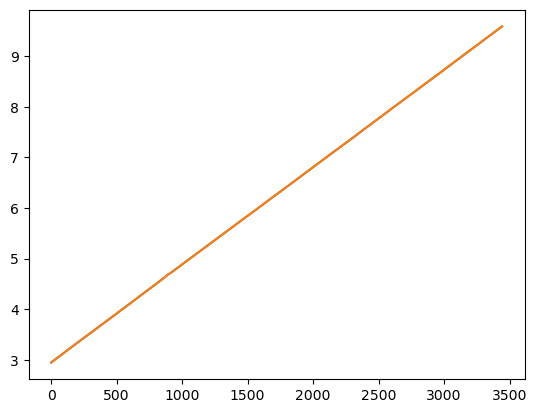

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(kiro_tei_list)), kiro_tei_list)
plt.show()

In [80]:
kiro_tei_list = []
for idx in range(50):
    image_path = base_images[idx]
    image_name = image_path.split('/')[-1]

    fname = image_name.split(".")[0]
    # print(f"image_path: {image_path}")
    # print(f"fname     : {fname}")

    idx_delta = base_images.index(image_path) - kiro_init_dict['image_idx_init'][0]
    if idx_delta > 0:
        # 上限以上の場合は、上限を基準とした idx_delta に更新する
        idx_delta = base_images.index(image_path) - kiro_init_dict['image_idx_init'][1]
    else:
        if idx_delta <= 0:
            kiro_tei = kiro_tei_init_head + idx_delta * 2 / config.img_width
        else:
            kiro_tei = kiro_tei_init_tail + idx_delta * 2 / config.img_width
    # print(f"idx_delta: {idx_delta}")
    # print(f"DenchuNo: {DenchuNo}")
    # print(f"kiro_tei: {round(kiro_tei, 4)}")
    
    kiro_tei_list.append(kiro_tei)
kiro_tei_list

[2.9478,
 2.9497999999999998,
 2.9518,
 2.9537999999999998,
 2.9558,
 2.9577999999999998,
 2.9598,
 2.9617999999999998,
 2.9638,
 2.9657999999999998,
 2.9678,
 2.9697999999999998,
 2.9718,
 2.9737999999999998,
 2.9758,
 2.9778,
 2.9798,
 2.9818,
 2.9838,
 2.9858,
 2.9878,
 2.9898,
 2.9918,
 2.9938,
 2.9958,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978,
 2.9978]

In [ ]:
if fname in kiro_dict[camera_num].keys():
    DenchuNo = kiro_dict[camera_num][fname]['DenchuNo']
    kiro_tei = kiro_dict[camera_num][fname]['KiroTei']
else:
    # 画像ファイル名がマッチしない場合のキロ程を指定
    if idx + count - 1 <= kiro_init_dict['image_idx_init'][0]:
        DenchuNo = 0
        kiro_tei = kiro_tei_init_head - (kiro_init_dict['image_idx_init'][0] - (idx + count - 1)) * 2 / config.img_width
    else:
        DenchuNo = 1000
        kiro_tei = kiro_tei_init_tail + ((idx + count - 1) - kiro_init_dict['image_idx_init'][1]) * 2 / config.img_width
print(f"DenchuNo: {DenchuNo}")
print(f"kiro_tei: {round(kiro_tei, 4)}")

In [37]:
if fname in kiro_dict[camera_num].keys():
    DenchuNo = kiro_dict[camera_num][fname]['DenchuNo']
    kiro_tei = kiro_dict[camera_num][fname]['KiroTei']
    # st.write(f"Match   > kiro_tei: {kiro_tei}")
else:
    # 画像ファイル名がマッチしない場合のキロ程を指定
    if idx + count - 1 <= kiro_init_dict['image_idx_init'][0]:
        DenchuNo = 0
        kiro_tei = kiro_tei_init_head - (kiro_init_dict['image_idx_init'][0] - (idx + count - 1)) * 2 / config.img_width
    else:
        DenchuNo = 1000
        kiro_tei = kiro_tei_init_tail + ((idx + count - 1) - kiro_init_dict['image_idx_init'][1]) * 2 / config.img_width
kiro_tei_list = [kiro_tei + ix / config.img_width / 1000 * 2 for ix in config.ix_list]

# 作業用ここまで

In [7]:
# チェック用
# JSONファイルの内容を読み込んでしてCSVで出力する

import pandas as pd
import json

# JSONファイルのパス
file_path = f'{config.tdm_dir}/{dir_area}.json'

# JSONファイルを読み込む
with open(file_path, 'r') as file:
    data = json.load(file)

# JSONデータからPandas DataFrameを作成
# 行名を階層的なキーから生成し、各カラムに値を設定
rows = []
for parent_key, child_dict in data.items():
    for child_key, attributes in child_dict.items():
        file_name = f"{parent_key}_{child_key}"
        rows.append({'file_name': file_name, 'DenchuNo': attributes['DenchuNo'], 'KiroTei': attributes['KiroTei']})

# データフレームを作成
df_json = pd.DataFrame(rows).set_index('file_name')

# JSONから変換したCSVファイルを作成
df_json.to_csv("TDM/{dir_area}.csv")
df_json

,DenchuNo,KiroTei
file_name,,
HD11_2023_0117_HD11_01_00015339,33,2.99980
HD11_2023_0117_HD11_01_00015340,33,3.00180
HD11_2023_0117_HD11_01_00015341,33,3.00380
HD11_2023_0117_HD11_01_00015342,33,3.00580
HD11_2023_0117_HD11_01_00015343,33,3.00780
...,...,...
HD32_2023_0117_HD32_01_00018752,1,9.58148
HD32_2023_0117_HD32_01_00018753,1,9.58350
HD32_2023_0117_HD32_01_00018754,1,9.58552


In [8]:
print("JSONファイルに含まれる電柱番号")
df_json['DenchuNo'].unique()

JSONファイルに含まれる電柱番号


array([ 33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 901,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27, 102,  28,  29,  30,  31,  32,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62, 902])

In [9]:
# 直接JSONファイルの中身を確認
with open(file_path, 'r') as file:
    data = json.load(file)

print("読み込まれたカメラ番号")
for key in data.keys():
    print(f"{key} img_counts:{len(data[key])}")

# 画像ファイル名を指定して中身をチェックする
data['HD11']['2023_0117_HD11_01_00015339']

読み込まれたカメラ番号
HD11 img_counts:3418
HD12 img_counts:3418
HD21 img_counts:3418
HD22 img_counts:3418
HD31 img_counts:3418
HD32 img_counts:3418


{'DenchuNo': 33, 'KiroTei': 2.9997999999999996}

In [12]:
image_name = "2023_0117_HD11_01_00015339.jpg"
image_name.split(".")[0]

'2023_0117_HD11_01_00015339'

In [17]:
data['HD11'][image_name.split(".")[0]]['DenchuNo']

33

In [19]:
data['HD11'][image_name.split(".")[0]]['KiroTei']

2.9997999999999996

# 作業用 結果CSVのチェック

In [174]:
dir_area = images_path[5]
dir_area

'Takasaki_99_Omiya-Kitaageo_down_20230509_day'

In [180]:
from glob import glob

output_list = glob(f"output/{dir_area}/HD21/*.csv")
output_list.sort()
len(output_list)

541

In [181]:
%%time
import pandas as pd


dfs = []
for csv_path in output_list:
    dfs.append(pd.read_csv(csv_path))
df = pd.concat(dfs, ignore_index=True)
df

<timed exec>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


CPU times: user 3.44 s, sys: 185 ms, total: 3.62 s
Wall time: 5.46 s


,image_idx,ix,pole_num,kiro_tei,measurement_area,camera_num,image_name,trolley_id,measured_upper_edge,measured_lower_edge,...,brightness_std,estimated_slope,upper_boundary,lower_boundary,estimated_upper_edge_variance,estimated_lower_edge_variance,estimated_slope_variance,trolley_end_reason,mask_edgelog_1,mask_edgelog_2
0,0.0,0,0.0,2.947800,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015314.jpg,trolley1,629.0,635.0,...,34.812500,0.000000,NaN,NaN,0.750488,0.750488,0.001049,NaN,0.0,0.0
1,0.0,1,0.0,2.947802,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015314.jpg,trolley1,629.0,635.0,...,34.968750,0.000000,NaN,NaN,0.602051,0.602051,0.001098,NaN,0.0,0.0
2,0.0,2,0.0,2.947804,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015314.jpg,trolley1,629.0,635.0,...,35.406250,0.000000,NaN,NaN,0.504395,0.503906,0.001144,NaN,0.0,0.0
3,0.0,3,0.0,2.947806,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015314.jpg,trolley1,629.0,635.0,...,35.687500,0.000000,NaN,NaN,0.435547,0.435547,0.001188,NaN,0.0,0.0
4,0.0,4,0.0,2.947808,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015314.jpg,trolley1,629.0,635.0,...,36.000000,0.000000,NaN,NaN,0.385498,0.385254,0.001229,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528834,521.0,521549,10.0,3.958188,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015835.jpg,trolley2,1020.0,1038.0,...,15.226562,-0.000112,NaN,NaN,0.159180,0.159058,0.000931,NaN,1.0,0.0
528835,521.0,521550,10.0,3.958190,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015835.jpg,trolley2,1020.0,1038.0,...,14.679688,0.000831,NaN,NaN,0.159180,0.159058,0.000931,NaN,1.0,0.0
528836,521.0,521551,10.0,3.958192,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015835.jpg,trolley2,1020.0,1038.0,...,13.906250,0.001719,NaN,NaN,0.159180,0.159058,0.000931,NaN,1.0,0.0
528837,521.0,521552,10.0,3.958194,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015835.jpg,trolley2,1020.0,1038.0,...,14.304688,0.002553,NaN,NaN,0.159180,0.159058,0.000931,NaN,1.0,0.0


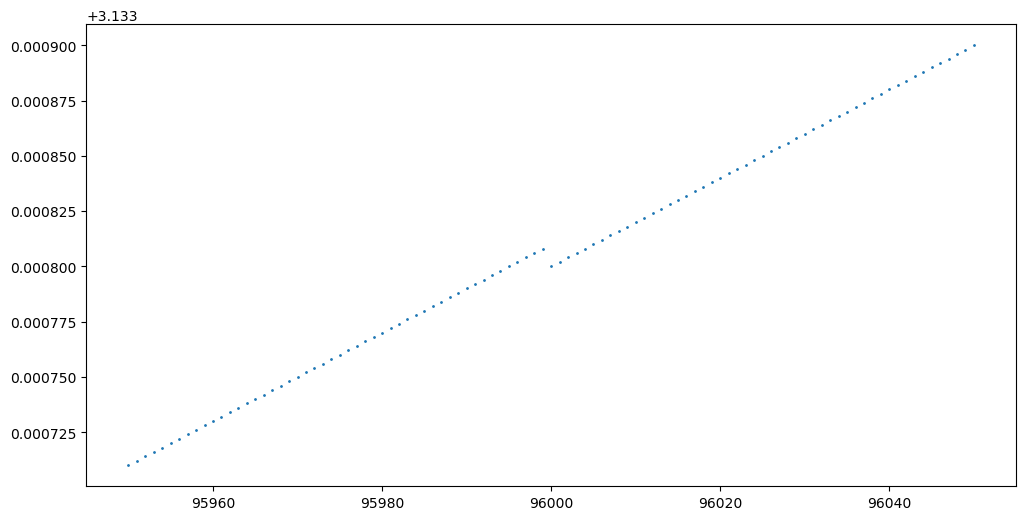

,image_idx,ix,pole_num,kiro_tei,measurement_area,camera_num,image_name,trolley_id,measured_upper_edge,measured_lower_edge,...,brightness_std,estimated_slope,upper_boundary,lower_boundary,estimated_upper_edge_variance,estimated_lower_edge_variance,estimated_slope_variance,trolley_end_reason,mask_edgelog_1,mask_edgelog_2
95950,95.0,95950,35.0,3.133710,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015409.jpg,trolley1,675.0,680.0,...,69.8125,-0.019549,NaN,NaN,0.158936,0.158936,0.000931,NaN,0.0,0.0
95951,95.0,95951,35.0,3.133712,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015409.jpg,trolley1,675.0,680.0,...,72.0000,-0.018469,NaN,NaN,0.158936,0.158936,0.000931,NaN,0.0,0.0
95952,95.0,95952,35.0,3.133714,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015409.jpg,trolley1,674.0,680.0,...,73.8750,-0.020134,NaN,NaN,0.158936,0.158936,0.000931,NaN,0.0,0.0
95953,95.0,95953,35.0,3.133716,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015409.jpg,trolley1,674.0,680.0,...,71.8750,-0.021518,NaN,NaN,0.158936,0.158936,0.000931,NaN,0.0,0.0
95954,95.0,95954,35.0,3.133718,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015409.jpg,trolley1,674.0,681.0,...,72.0625,-0.019909,NaN,NaN,0.158936,0.158936,0.000931,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96046,96.0,96046,36.0,3.133892,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015410.jpg,trolley1,673.0,679.0,...,72.3125,-0.026459,NaN,NaN,0.186035,0.185791,0.000935,NaN,0.0,0.0
96047,96.0,96047,36.0,3.133894,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015410.jpg,trolley1,673.0,679.0,...,73.4375,-0.027457,NaN,NaN,0.185059,0.184937,0.000934,NaN,0.0,0.0
96048,96.0,96048,36.0,3.133896,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015410.jpg,trolley1,673.0,679.0,...,74.3750,-0.028199,NaN,NaN,0.184204,0.183960,0.000933,NaN,0.0,0.0
96049,96.0,96049,36.0,3.133898,Takasaki_99_Omiya-Kitaageo_down_20230509_day,HD21,2023_0117_HD21_01_00015410.jpg,trolley1,673.0,679.0,...,84.9375,-0.028708,NaN,NaN,0.183350,0.183228,0.000932,NaN,0.0,0.0


In [210]:
import matplotlib.pyplot as plt

# 画像ファイルごとの境界部のキロ程が、ちゃんとつながっているかをチェックする
target_image_idx = 96
view_range = 50

df_temp = df.query(f"{target_image_idx * 1000 - view_range} <= ix <= {target_image_idx * 1000 + view_range}")
plt.figure(figsize=(12,6))
plt.scatter(df_temp['ix'], df_temp['kiro_tei'], linestyle="None", marker="o", s=1)
plt.show()
df_temp